## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [1]:
import matplotlib.pyplot as plt
import numpy as np, random
import tensorflow as tf
from tensorflow.keras import layers, models

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [2]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [3]:
#label for 0 is 10, let's change that

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

## Extract a random validation set from the training set
In this case the size of the validation set is 7% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [4]:
#Divide training and validation
#validation set size is 7% of training set
validation_percentage = 0.07
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((68130, 32, 32, 3), (5127, 32, 32, 3), (68130, 1), (5127, 1))

## Visualize the images

In [5]:
#Function to visualize image with their respective labels
def plot_img(images, labels, images_number=4):
    plt.figure(figsize=(8,8))
    for i in range(images_number**2):
        plt.subplot(images_number, images_number, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,:], cmap=plt.cm.binary)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

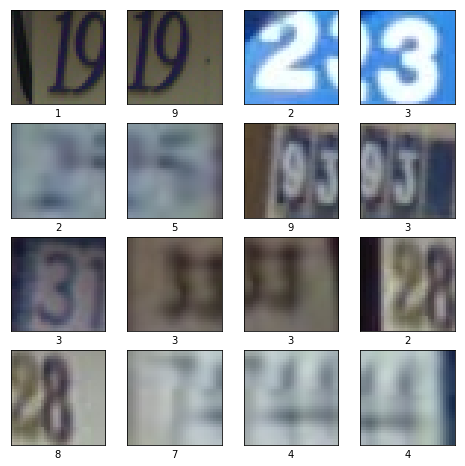

In [6]:
#Check if the training set is divided correctely and print the data
plot_img(train_img, train_lbs)

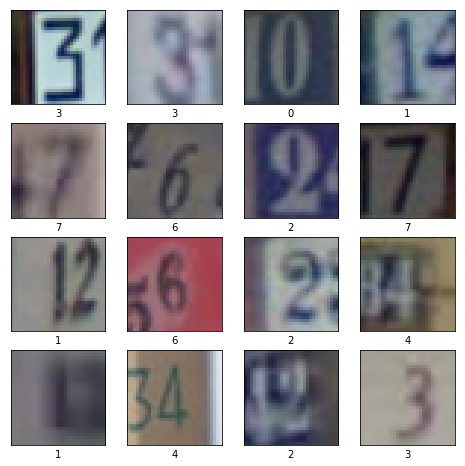

In [7]:
#Check if the validation set is divided correctely and print the data
plot_img(validation_img, validation_lbs)

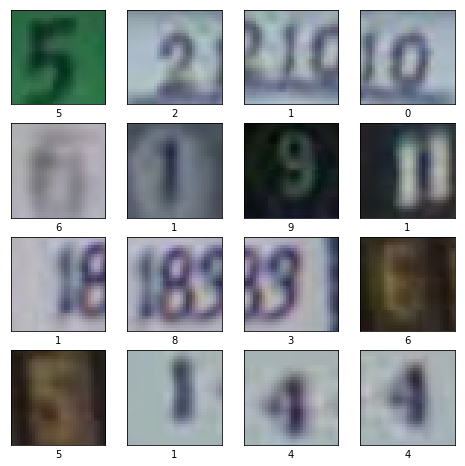

In [8]:
#Check if the test set is divided correctely and print the data
plot_img(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [9]:
#cast to float otherwise during mean subtraction floats would be casted to ints
train_img = train_img.astype(float)

#zero center across each colour channel
rmean = np.mean(train_img[:,:,:,0])
bmean = np.mean(train_img[:,:,:,1])
gmean = np.mean(train_img[:,:,:,2])

train_img[:,:,:,0] = train_img[:,:,:,0]-rmean
train_img[:,:,:,1] = train_img[:,:,:,1]-bmean
train_img[:,:,:,2] = train_img[:,:,:,2]-gmean


#normalize by dividing each dimension colour channel by its standard deviation
rstd = np.std(train_img[:,:,:,0])
bstd = np.std(train_img[:,:,:,1])
gstd = np.std(train_img[:,:,:,2])

train_img[:,:,:,0] = train_img[:,:,:,0]/rstd
train_img[:,:,:,1] = train_img[:,:,:,1]/bstd
train_img[:,:,:,2] = train_img[:,:,:,2]/gstd

In [10]:
#do the same on the validation set and training set
test_img = test_img.astype(float)
validation_img = validation_img.astype(float)

test_img[:,:,:,0] = test_img[:,:,:,0]-rmean
test_img[:,:,:,1] = test_img[:,:,:,1]-bmean
test_img[:,:,:,2] = test_img[:,:,:,2]-gmean

test_img[:,:,:,0] = test_img[:,:,:,0]/rstd
test_img[:,:,:,1] = test_img[:,:,:,1]/bstd
test_img[:,:,:,2] = test_img[:,:,:,2]/gstd

validation_img[:,:,:,0] = validation_img[:,:,:,0]-rmean
validation_img[:,:,:,1] = validation_img[:,:,:,1]-bmean
validation_img[:,:,:,2] = validation_img[:,:,:,2]-gmean

validation_img[:,:,:,0] = validation_img[:,:,:,0]/rstd
validation_img[:,:,:,1] = validation_img[:,:,:,1]/bstd
validation_img[:,:,:,2] = validation_img[:,:,:,2]/gstd


In [11]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [12]:
#we are now going ot start hyperparameter evaluation

#the basic network structure will be
# (conv2dLayer*N(filterSize*L) -> (maxPool or Stride))*M -> (FCnonlinear -> FCsoftmax) or (Global avarage pooling)

#we start by testing what M should be, leaving the other parameters to a default
val_models = []

#create 3 model with M=1 to 3
model_number = 3
for i in range(model_number):
    model = models.Sequential()
    model.add(layers.Conv2D(24, (5,5), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.MaxPooling2D())
    if i > 0:
        model.add(layers.Conv2D(48, (5,5), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    if i > 1:
        model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 24)        1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                393280    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 395,754
Trainable params: 395,754
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

In [13]:
#validate models
val_errors = []
epoch_num = 10

for i in range(model_number):
    val_errors[i] = val_models[i].fit(train_img, train_lbs, batch_size=64, epochs=epoch_num,
                                      validation_data=(validation_img, validation_lbs))

Train on 68130 samples, validate on 5127 samples
Epoch 1/10
68130/68130 [==============================] - 82s 1ms/sample - loss: 1.0024 - acc: 0.6868 - val_loss: 0.6893 - val_acc: 0.8026
Epoch 2/10
19712/68130 [=======>......................] - ETA: 46s - loss: 0.6363 - acc: 0.8161

KeyboardInterrupt: 

In [ ]:

for i in range(model_number):
    plt.plot(models[i].history['accuracy'], label='accuracy'+str(i))
    plt.plot(models[i].history['val_acc'], lable='accuracy'+str(i))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)